# 数据集Dataloader制作

### 如何自定义数据集：

- 1.数据和标签的目录结构先搞定(得知道到哪读数据)
- 2.写好读取数据和标签路径的函数(根据自己数据集情况来写)
- 3.完成单个数据与标签读取函数(给dataloader举一个例子)

### 以花朵数据集为例：

- 原来数据集都是以文件夹为类别ID，现在咱们换一个套路，用txt文件指定数据路径与标签
- 这回咱们的任务就是在txt文件中获取图像路径与标签，然后把他们交给dataloader
- 核心代码非常简单，按照对应格式传递需要的数据和标签就可以了

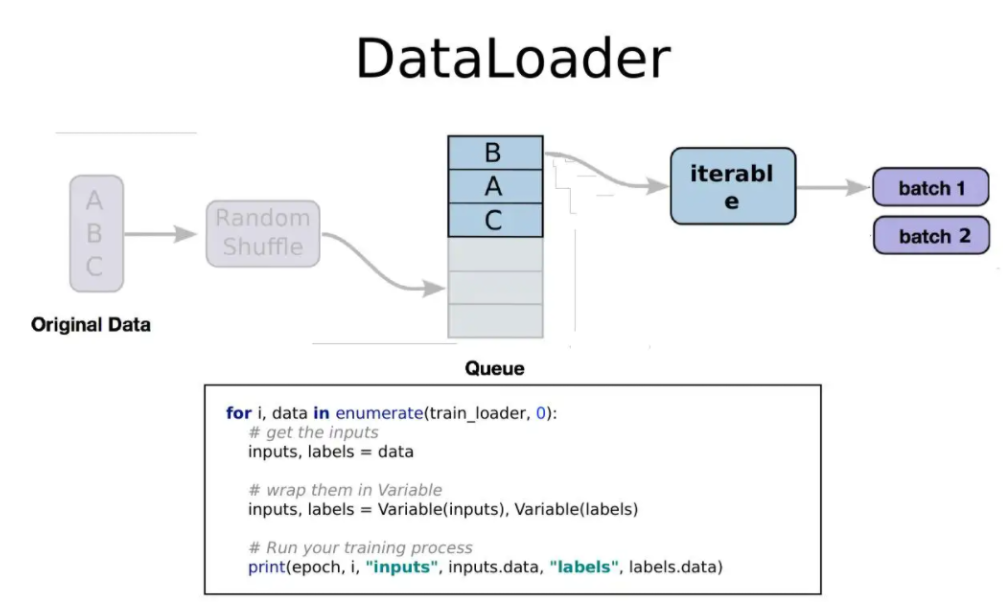


In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models, datasets
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

#### 任务1：读取txt文件中的路径和标签

- 第一个小任务，从标注文件中读取数据和标签
- 至于你准备存成什么格式，都可以，一会能取出来东西就行

In [2]:
def load_annotations(ann_file):
    data_infos = {}
    with open(ann_file) as f:
        samples = [x.strip().split(' ') for x in f.readlines()]
        for filename, gt_label in samples:
            data_infos[filename] = np.array(gt_label, dtype=np.int64)
    return data_infos

#### 任务2：分别把数据和标签都存在list里

In [3]:
img_label = load_annotations('./flower_data/train.txt')

image_name = list(img_label.keys())
label = list(img_label.values())

#### 任务3：图像数据路径得完整

In [4]:
data_dir = './flower_data/'
train_dir = data_dir + '/train_filelist'
valid_dir = data_dir + '/val_filelist'

image_path = [os.path.join(train_dir,img) for img in image_name]

#### 任务4：把上面那几个事得写在一起

- 1.注意要使用from torch.utils.data import Dataset, DataLoader
- 2.类名定义class FlowerDataset(Dataset)，其中FlowerDataset可以改成自己的名字
- 3.def __init__(self, root_dir, ann_file, transform=None):咱们要根据自己任务重写
- 4.def __getitem__(self, idx):根据自己任务，返回图像数据和标签数据

In [ ]:
from torch.utils.data import Dataset, DataLoader
class FlowerDataset(Dataset):
    def __init__(self, root_dir, ann_file, transform=None):
        self.ann_file = ann_file
        self.root_dir = root_dir
        self.img_label = self.load_annotations()
        self.img = [os.path.join(self.root_dir,img) for img in list(self.img_label.keys())]
        self.label = [label for label in list(self.img_label.values())]
        self.transform = transform
 
    def __len__(self):
        return len(self.img)
 
    def __getitem__(self, idx):
        image = Image.open(self.img[idx])
        label = self.label[idx]
        if self.transform:
            image = self.transform(image)
        label = torch.from_numpy(np.array(label))
        return image, label
    
    def load_annotations(self):
        data_infos = {}
        with open(self.ann_file) as f:
            samples = [x.strip().split(' ') for x in f.readlines()]
            for filename, gt_label in samples:
                data_infos[filename] = np.array(gt_label, dtype=np.int64)
        return data_infos

#### 任务5：数据预处理(transform)

- 1.预处理的事都在上面的__getitem__中完成，需要对图像和标签咋咋地的，要整啥事，都在上面整
- 2.返回的数据和标签就是建模时模型的输入和损失函数中标签的输入，一定整明白自己模型要啥
- 3.预处理这个事是你定的，不同的数据需要的方法也不一样，下面给出的是比较通用的方法

In [6]:
data_transforms = {
    'train': 
        transforms.Compose([
        transforms.Resize(64),
        transforms.RandomRotation(45),#随机旋转，-45到45度之间随机选
        transforms.CenterCrop(64),#从中心开始裁剪
        transforms.RandomHorizontalFlip(p=0.5),#随机水平翻转 选择一个概率概率
        transforms.RandomVerticalFlip(p=0.5),#随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),#参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
        transforms.RandomGrayscale(p=0.025),#概率转换成灰度率，3通道就是R=G=B
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#均值，标准差
    ]),
    'valid': 
        transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#### 任务6：根据写好的class FlowerDataset(Dataset):来实例化咱们的dataloader

- 1.构建数据集：分别创建训练和验证用的数据集（如果需要测试集也一样的方法）
- 2.用Torch给的DataLoader方法来实例化(batch啥的自己定，根据你的显存来选合适的)
- 3.打印看看数据里面是不是有东西了

In [7]:
train_dataset = FlowerDataset(root_dir=train_dir, ann_file = './flower_data/train.txt', transform=data_transforms['train'])
val_dataset = FlowerDataset(root_dir=valid_dir, ann_file = './flower_data/val.txt', transform=data_transforms['valid'])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)


#### 任务7：用之前先试试，整个数据和标签对应下，看看对不对

- 1.别着急往模型里传，对不对都不知道呢
- 2.用这个方法：iter(train_loader).next()来试试，得到的数据和标签是啥
- 3.看不出来就把图画出来，标签打印出来，确保自己整的数据集没啥问题

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4305114e-08..0.8313725].


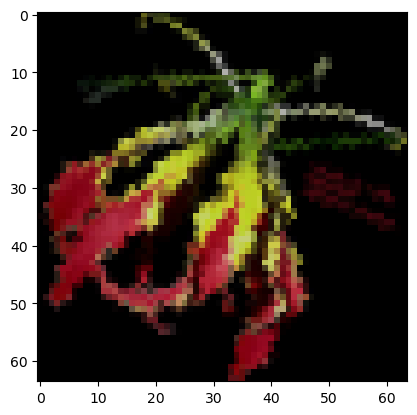

Label is: 20


In [11]:
image, label = next(iter(train_loader))
sample = image[0].squeeze()
sample = sample.permute((1, 2, 0)).numpy()
sample *= [0.229, 0.224, 0.225]
sample += [0.485, 0.456, 0.406]
plt.imshow(sample)
plt.show()
print('Label is: {}'.format(label[0].numpy()))


#### 任务8：将数据导入模型

In [12]:
dataloaders = {'train':train_loader,'valid':val_loader}

model_name = 'resnet'  #可选的比较多 ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']
#是否用人家训练好的特征来做
feature_extract = True 

# 是否用GPU训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet18()

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 102))
input_size = 64


# 优化器设置
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)#学习率每7个epoch衰减成原来的1/10
criterion = nn.CrossEntropyLoss()

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, filename='best.pth'):
    since = time.time()
    best_acc = 0
    model.to(device)

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    #print(loss)

                    # 训练阶段更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            
            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),#字典里key就是各层的名字，值就是训练好的权重
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),#优化器的状态信息
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)#学习率衰减
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果,等着一会测试
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs 

CUDA is not available.  Training on CPU ...


In [13]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=20, filename='best.pth')

Epoch 0/19
----------
Time elapsed 1m 12s
train Loss: 3.9833 Acc: 0.0850
Time elapsed 1m 16s
valid Loss: 3.4376 Acc: 0.1345
Optimizer learning rate : 0.0010000

Epoch 1/19
----------


d:\App\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Time elapsed 3m 10s
train Loss: 3.3856 Acc: 0.1687
Time elapsed 3m 15s
valid Loss: 2.9870 Acc: 0.2225
Optimizer learning rate : 0.0010000

Epoch 2/19
----------
Time elapsed 4m 27s
train Loss: 3.0974 Acc: 0.2150
Time elapsed 4m 31s
valid Loss: 2.9382 Acc: 0.2482
Optimizer learning rate : 0.0010000

Epoch 3/19
----------
Time elapsed 5m 39s
train Loss: 2.8423 Acc: 0.2688
Time elapsed 5m 43s
valid Loss: 2.6352 Acc: 0.3105
Optimizer learning rate : 0.0010000

Epoch 4/19
----------
Time elapsed 6m 46s
train Loss: 2.6351 Acc: 0.3100
Time elapsed 6m 50s
valid Loss: 2.6094 Acc: 0.3142
Optimizer learning rate : 0.0010000

Epoch 5/19
----------
Time elapsed 7m 49s
train Loss: 2.4610 Acc: 0.3506
Time elapsed 7m 53s
valid Loss: 2.5479 Acc: 0.3374
Optimizer learning rate : 0.0010000

Epoch 6/19
----------
Time elapsed 8m 53s
train Loss: 2.2772 Acc: 0.3898
Time elapsed 8m 57s
valid Loss: 2.2551 Acc: 0.3802
Optimizer learning rate : 0.0010000

Epoch 7/19
----------
Time elapsed 9m 56s
train Loss: 2.